In [1]:
import utils
import xarray as xr
import pandas as pd
import numpy as np
import fair
import matplotlib.pyplot as plt
import faceted
import seaborn as sns

/home/tarshish/micromamba/envs/zec/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
utils.set_plot_configs(plt, fsize=8)

In [3]:
scenarios=["historical","ssp119", "ssp126","ssp534-over"]
f = utils.gen_fair_ensemble(scenarios, final_year=2400)
f._make_indices()
emissions = f.emissions.isel(config=0)
#make total CO2 by adding FFI and AFOLU 
emissions[...,2] = emissions[...,0] + emissions[...,1]  
ghg_emissions = emissions[..., f._ghg_indices]
ghg_names = np.array(f.species)[f._ghg_indices]

In [22]:
#find correspondence between AR6 names and FaIR names
GWP_table = pd.read_csv("../../dependencies/AR6_GWP_values.csv")

alternative_names = {
    'c-C4F8': 'PFC-C-318',
    'C4F10': 'PFC-31-10',
    'C5F12': 'PFC-41-12',
    'C6F14': 'PFC-51-14',
    'C7F16': 'PFC-61-16',
    'C8F18': 'PFC-71-18',
    'HFC-4310mee': 'HFC-43-10mee'
}

GWP_100 = {}
for specie in ghg_names:
    if specie in GWP_table.Formula.values:
        GWP_100[specie] = GWP_table.loc[GWP_table.Formula.values == specie]["GWP100"].item()
    elif specie in GWP_table.Acronym.values:
        GWP_100[specie] = GWP_table.loc[GWP_table.Acronym.values == specie]["GWP100"].item()
    elif specie in alternative_names.keys():
        key = alternative_names[specie]
        GWP_100[specie] = GWP_table.loc[GWP_table.Acronym.values == key]["GWP100"].item()
    else:
        print(specie)

In [23]:

#GWP converts Mt of species X to MtCO2, so need to convert all FaIR quantities to Mt
unit_conversion = {}
units = fair.structure.units.desired_emissions_units
for unit in units.keys():
    if units[unit].split()[0] == "Gt":
        unit_conversion[unit] = 1e3
    if units[unit].split()[0] == "Mt":
        unit_conversion[unit] = 1
    if units[unit].split()[0] == "kt":
        unit_conversion[unit] = 1e-3

#THE KEY LINE
#converting to CO2_equivalent
for specie in ghg_emissions.specie:
    ghg_emissions[..., ghg_emissions.specie == specie] = GWP_100[specie.item()]*unit_conversion[specie.item()]*ghg_emissions[..., ghg_emissions.specie == specie]

In [24]:
#total
ghg_total = ghg_emissions.sum("specie")

In [25]:
#find the net-zero time by the change of sign
net_zero_GHG_time = (
    ghg_total
    .groupby("scenario") 
    .apply(lambda x: x.where(np.sign(x).diff("timepoints") == -2, drop=True).timepoints)
)

#reduce dimensionally by summing over Nans 
net_zero_GHG_time = net_zero_GHG_time.sum("timepoints")

/tmp/ipykernel_122808/4261638234.py:5: UserWarning: The `squeeze` kwarg to GroupBy is being removed.Pass .groupby(..., squeeze=False) to disable squeezing, which is the new default, and to silence this warning.
  .apply(lambda x: x.where(np.sign(x).diff("timepoints") == -2, drop=True).timepoints)


In [26]:
net_zero_GHG_time.name = "net_zero_GHG_time"

In [27]:
#a slight misnomer, but for historical we set the value to 2024 to perform the zec experiment 
net_zero_GHG_time[0] = 2024.5

In [28]:
net_zero_GHG_time.to_netcdf("../../results/net_zero_times.nc")

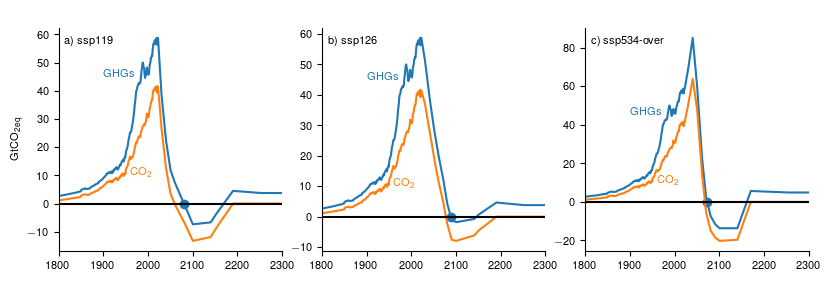

In [31]:
blue, orange = sns.color_palette("tab10")[:2]

fig, axes = faceted.faceted(1,3, sharey=False, internal_pad=.4, aspect=1.0)
for scenario, axis, label in zip(scenarios[1:], axes, ["a)","b)","c)"]):
    GtCO2_eq = ghg_emissions.sel(scenario=scenario).sum("specie")/1e3
    GtCO2_eq.plot(ax=axis, color=blue)
    GtCO2=ghg_emissions.sel(scenario=scenario).sel(specie="CO2")/1e3
    GtCO2.plot(ax=axis, color=orange)
    axis.scatter(net_zero_GHG_time.sel(scenario=scenario), 0, color=blue)
    axis.axhline(0, color="black")
    axis.set_title(" ")
    axis.text(.025, .925, label+" "+scenario, transform=axis.transAxes)
    axis.text(1900, 45, "GHGs", color=blue)
    axis.text(1960, 10, "CO$_2$", color=orange)

    axis.set_xlim([1800, 2300])
    axis.set_xlabel(" ")
    sns.despine()

axes[0].set_ylabel("GtCO$_{2\,\\text{eq}}$")
fig.savefig("../../results/figures/net_zero_times.pdf", bbox_inches="tight")